In [1]:
import os
import glob
import json
import random
import datetime
import re
import cv2
import math
from typing import List, Optional, Dict, Any, Tuple

import numpy as np
from pathlib import Path

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import ttest_ind

from captum.concept import TCAV, Concept, Classifier
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


from model.model import Net
from tools import utils, plotting, metrics, model_io, tcav, data


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(128),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )(img)

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("L")
    return transform(img)


def load_image_tensors(class_name, root_path='data/concepts', transform=True):
    path = os.path.join(root_path, class_name)

    patterns = ('*.png', '*.jpg', '*.jpeg', '*.bmp')
    filenames = []
    for pat in patterns:
        filenames.extend(glob.glob(os.path.join(path, pat)))

    if not filenames:
        print(f"[load_image_tensors] no files under: {os.path.abspath(path)}")

    images = []
    for filename in sorted(filenames):
        img = Image.open(filename).convert('L')
        images.append(transform(img) if callable(transform) else img)
    return images


In [4]:
def assemble_concept(name, id, concepts_path="data/concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [5]:
concepts_path = "./data/concepts"

circle_full        = assemble_concept("circle_full", 0, concepts_path=concepts_path)
circle_half_bottom = assemble_concept("circle_half_bottom", 1, concepts_path=concepts_path)
circle_half_left   = assemble_concept("circle_half_left", 2, concepts_path=concepts_path)
circle_half_right  = assemble_concept("circle_half_right", 3, concepts_path=concepts_path)
circle_half_top    = assemble_concept("circle_half_top", 4, concepts_path=concepts_path)

circle_quarter_bl  = assemble_concept("circle_quarter_bl", 5, concepts_path=concepts_path)
circle_quarter_br  = assemble_concept("circle_quarter_br", 6, concepts_path=concepts_path)
circle_quarter_tl  = assemble_concept("circle_quarter_tl", 7, concepts_path=concepts_path)
circle_quarter_tr  = assemble_concept("circle_quarter_tr", 8, concepts_path=concepts_path)

cross_arm_bottom   = assemble_concept("cross_arm_bottom", 9, concepts_path=concepts_path)
cross_arm_left     = assemble_concept("cross_arm_left", 10, concepts_path=concepts_path)
cross_arm_right    = assemble_concept("cross_arm_right", 11, concepts_path=concepts_path)
cross_arm_top      = assemble_concept("cross_arm_top", 12, concepts_path=concepts_path)
cross_arm_horizontal = assemble_concept("cross_arm_horizontal", 13, concepts_path=concepts_path)
cross_arm_vertical   = assemble_concept("cross_arm_vertical", 14, concepts_path=concepts_path)
cross_full         = assemble_concept("cross_full", 15, concepts_path=concepts_path)

random_pool        = assemble_concept("random_pool", 16, concepts_path=concepts_path)
random_pool_2        = assemble_concept("random_pool_2", 17, concepts_path=concepts_path)

square_corner_bl   = assemble_concept("square_corner_bl", 18, concepts_path=concepts_path)
square_corner_br   = assemble_concept("square_corner_br", 19, concepts_path=concepts_path)
square_corner_tl   = assemble_concept("square_corner_tl", 20, concepts_path=concepts_path)
square_corner_tr   = assemble_concept("square_corner_tr", 21, concepts_path=concepts_path)

square_edge_bottom = assemble_concept("square_edge_bottom", 22, concepts_path=concepts_path)
square_edge_left   = assemble_concept("square_edge_left", 23, concepts_path=concepts_path)
square_edge_right  = assemble_concept("square_edge_right", 24, concepts_path=concepts_path)
square_edge_top    = assemble_concept("square_edge_top", 25, concepts_path=concepts_path)

square_full        = assemble_concept("square_full", 26, concepts_path=concepts_path)
square_half_bottom = assemble_concept("square_half_bottom", 27, concepts_path=concepts_path)
square_half_left   = assemble_concept("square_half_left", 28, concepts_path=concepts_path)
square_half_right  = assemble_concept("square_half_right", 29, concepts_path=concepts_path)
square_half_top    = assemble_concept("square_half_top", 30, concepts_path=concepts_path)

ALL_CONCEPTS = [
    circle_full,
    circle_half_bottom, circle_half_left, circle_half_right, circle_half_top,
    circle_quarter_bl, circle_quarter_br, circle_quarter_tl, circle_quarter_tr,
    cross_arm_bottom, cross_arm_left, cross_arm_right, cross_arm_top,
    cross_arm_horizontal, cross_arm_vertical, cross_full,
    square_corner_bl, square_corner_br, square_corner_tl, square_corner_tr,
    square_edge_bottom, square_edge_left, square_edge_right, square_edge_top,
    square_full, square_half_bottom, square_half_left, square_half_right, square_half_top,
]

RANDOM_POOL = [random_pool, random_pool_2]

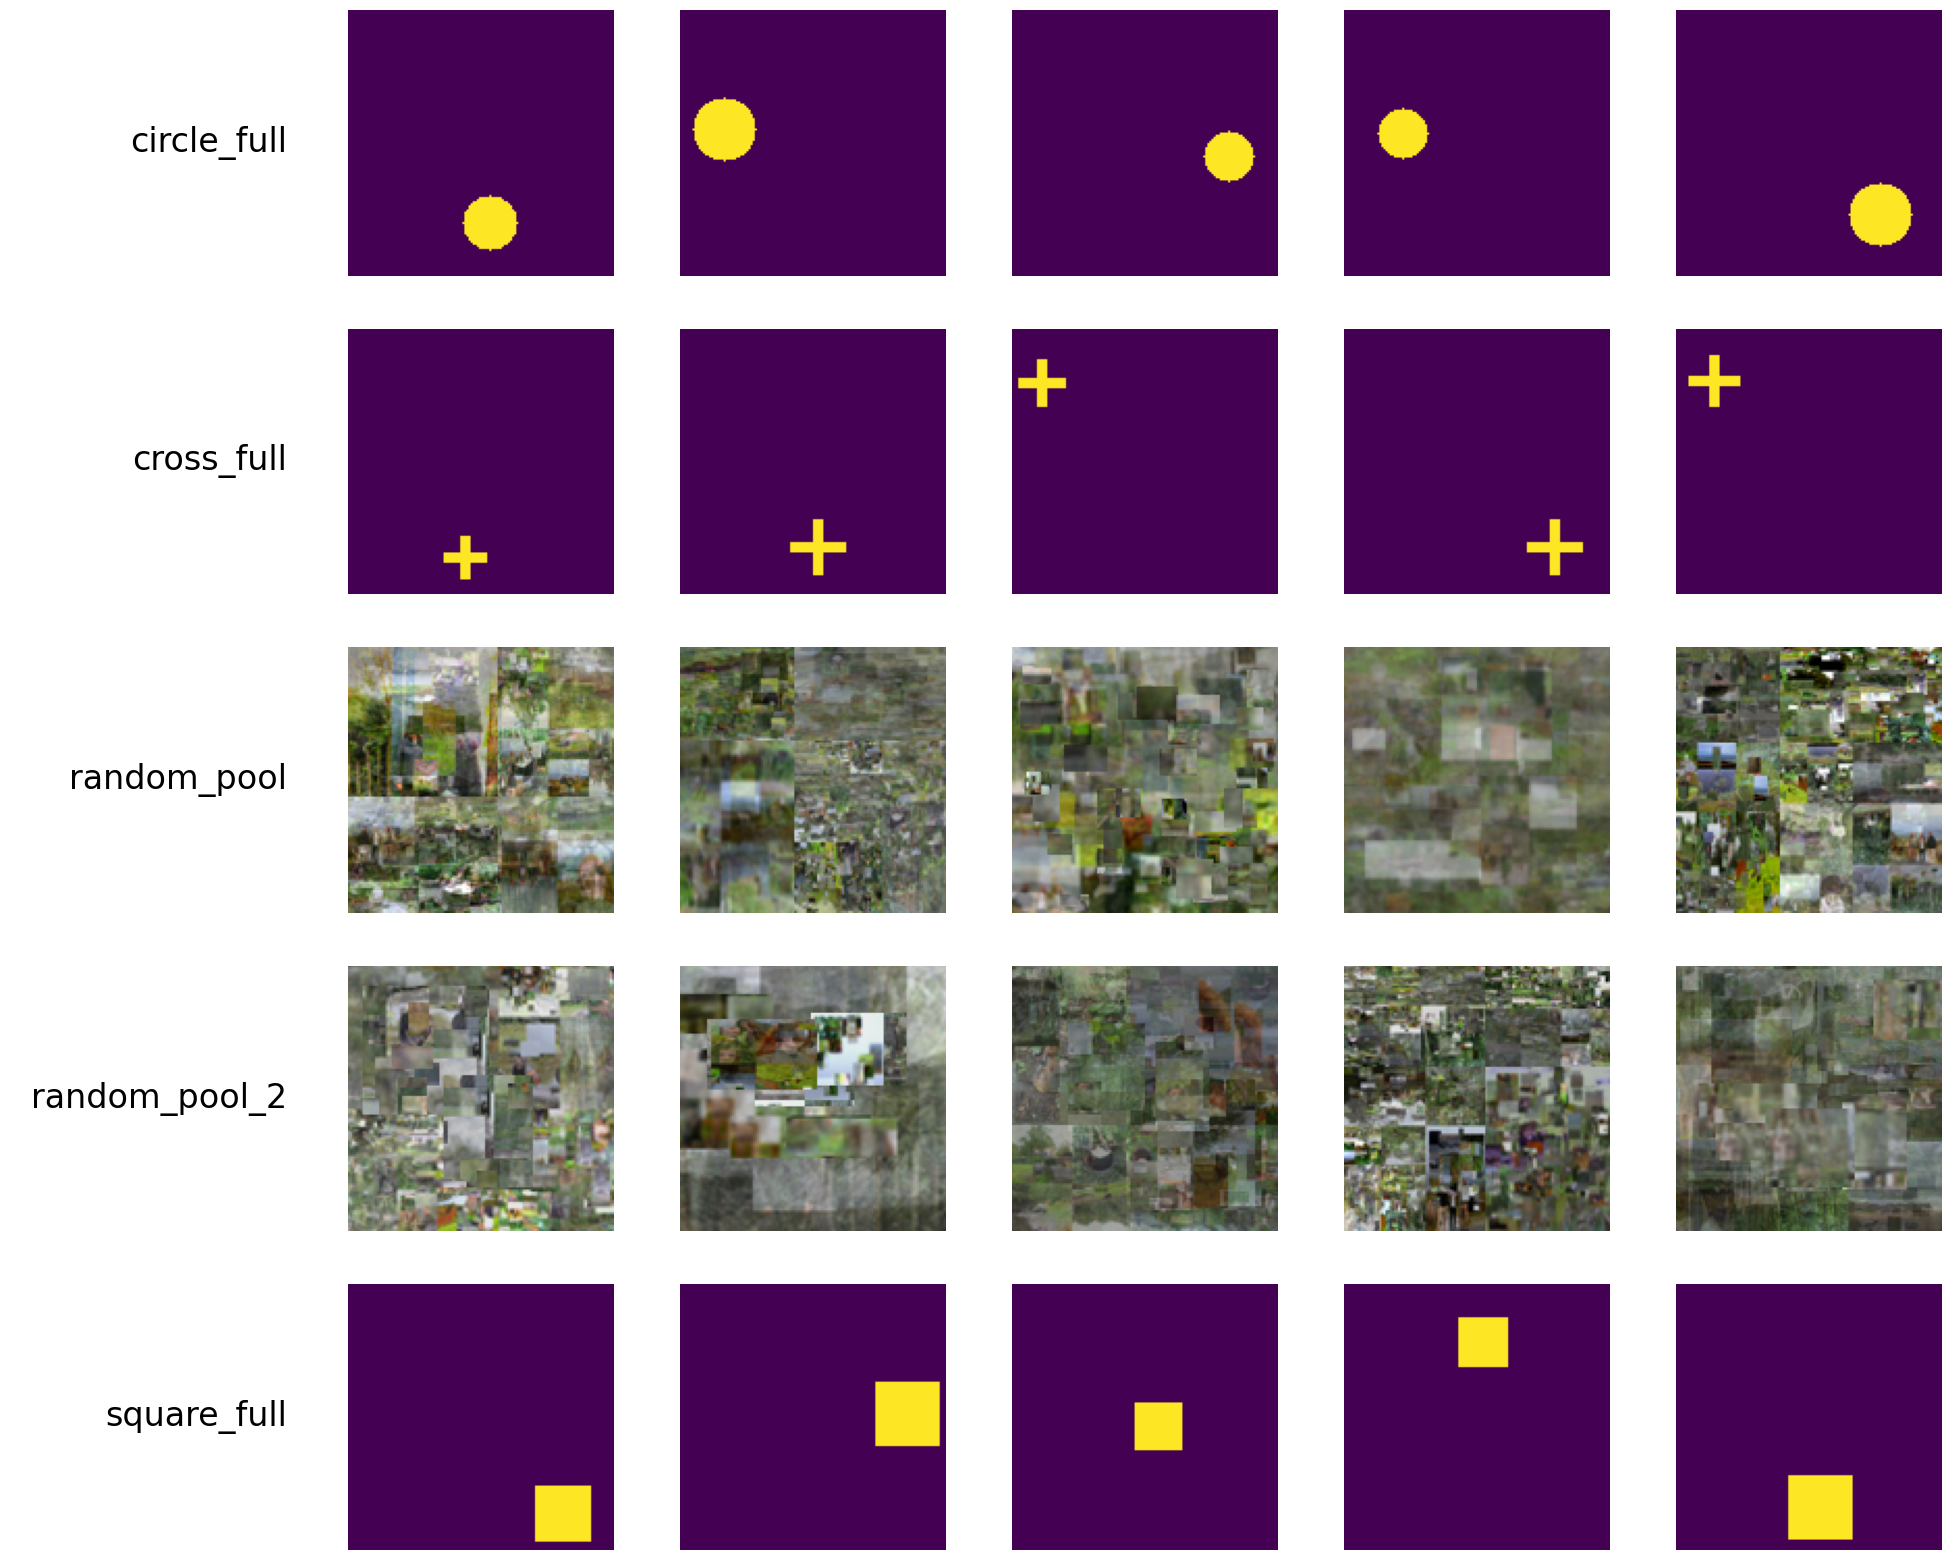

In [6]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([circle_full, cross_full, random_pool, random_pool_2, square_full]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [7]:
DEVICE = torch.device("cpu")
CKPT   = Path("weights/pesos.pt")

def _load_state_dict(ckpt_path: Path) -> dict:
    obj = torch.load(ckpt_path, map_location="cpu")
    if isinstance(obj, dict) and ("state_dict" in obj or "model_state_dict" in obj):
        sd = obj.get("state_dict", obj.get("model_state_dict"))
    else:
        sd = obj
    sd = { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }
    return sd

sd = _load_state_dict(CKPT)

in_channels = sd["conv1.weight"].shape[1]                 
try:
    num_classes = sd["fc4.weight"].shape[0]               
except KeyError:
    fc_weights = [(k, v) for k, v in sd.items() if k.endswith(".weight") and v.ndim == 2]
    assert fc_weights, "Couldn't infer num_classes from checkpoint."
    num_classes = fc_weights[-1][1].shape[0]

model = Net(numChannels=in_channels, classes=num_classes, size_img=128)
model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print(f"[OK] Loaded Net(in_channels={in_channels}, classes={num_classes}) on {DEVICE}")


[OK] Loaded Net(in_channels=1, classes=1) on cpu


In [8]:
LAYER_NAMES = ["relu3", "relu4", "relu5", "fc3"]
mytcav = TCAV(model=model,
              layers=LAYER_NAMES,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

/opt/miniconda3/lib/python3.12/site-packages/captum/concept/_core/tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


In [9]:
experimental_set_rand = [[cross_full, random_pool], [cross_full, random_pool_2]]

In [10]:
experimental_set_rand = [[cross_full, random_pool], [cross_full, random_pool_2]]

In [11]:
cross_set = load_image_tensors("cross_full", transform=False)

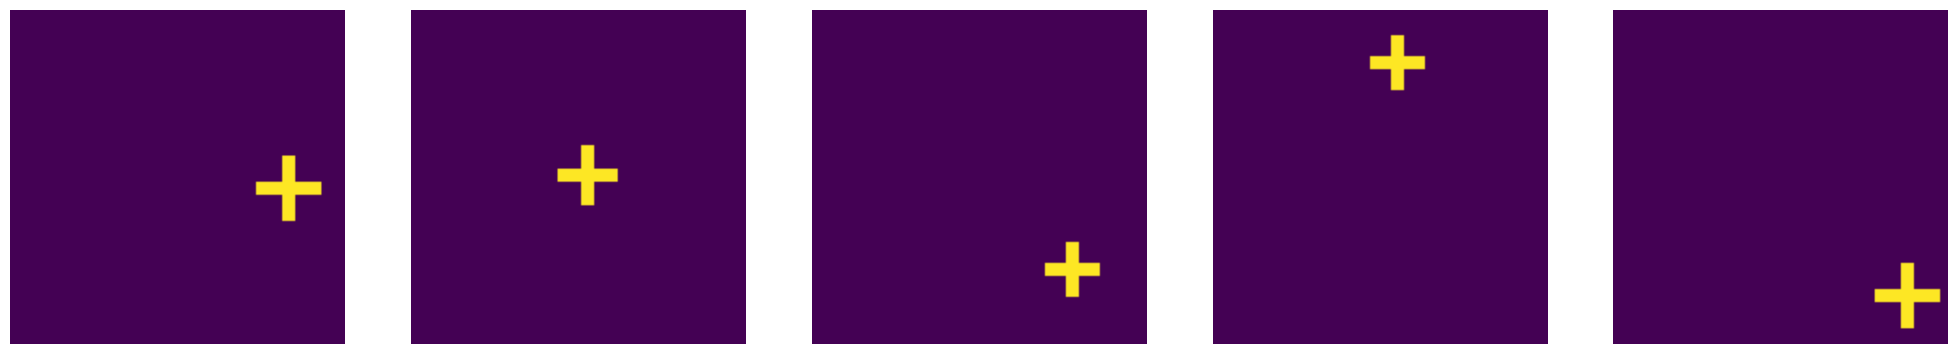

In [12]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(cross_set[40])
axs[1].imshow(cross_set[41])
axs[2].imshow(cross_set[34])
axs[3].imshow(cross_set[31])
axs[4].imshow(cross_set[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [13]:
cross_tensors = torch.stack([transform(img) for img in cross_set])
experimental_set_rand

[[Concept(15, 'cross_full'), Concept(16, 'random_pool')],
 [Concept(15, 'cross_full'), Concept(17, 'random_pool_2')]]

In [14]:
x_local = transform(Image.open("/Users/dylancanning/Desktop/Tcav_Captum/Testing-with-Concept-Activation-Vectors/data/aixi_shape/val/00106.png").convert("L")).unsqueeze(0) 

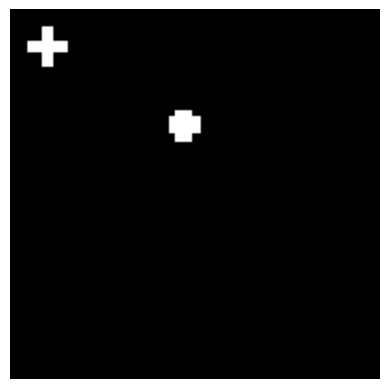

In [15]:

img_path = "/Users/dylancanning/Desktop/Tcav_Captum/Testing-with-Concept-Activation-Vectors/data/aixi_shape/val/00106.png"
img = Image.open(img_path).convert("L")


plt.imshow(img, cmap='gray') 
plt.axis('off') 
plt.show()

In [24]:
scores_local = mytcav.interpret(
    inputs=x_local,
    experimental_sets=experimental_set_rand,   
    target=None,
    processes=0,             
    n_steps=8,
    internal_batch_size=1,
)

In [18]:
experimental_set_shapes = [[cross_full, circle_full, square_full]]

scores_shapes = mytcav.interpret(
    inputs=x_local,
    experimental_sets=experimental_set_shapes,
    target=None,           
    n_steps=8,
    internal_batch_size=1,
)

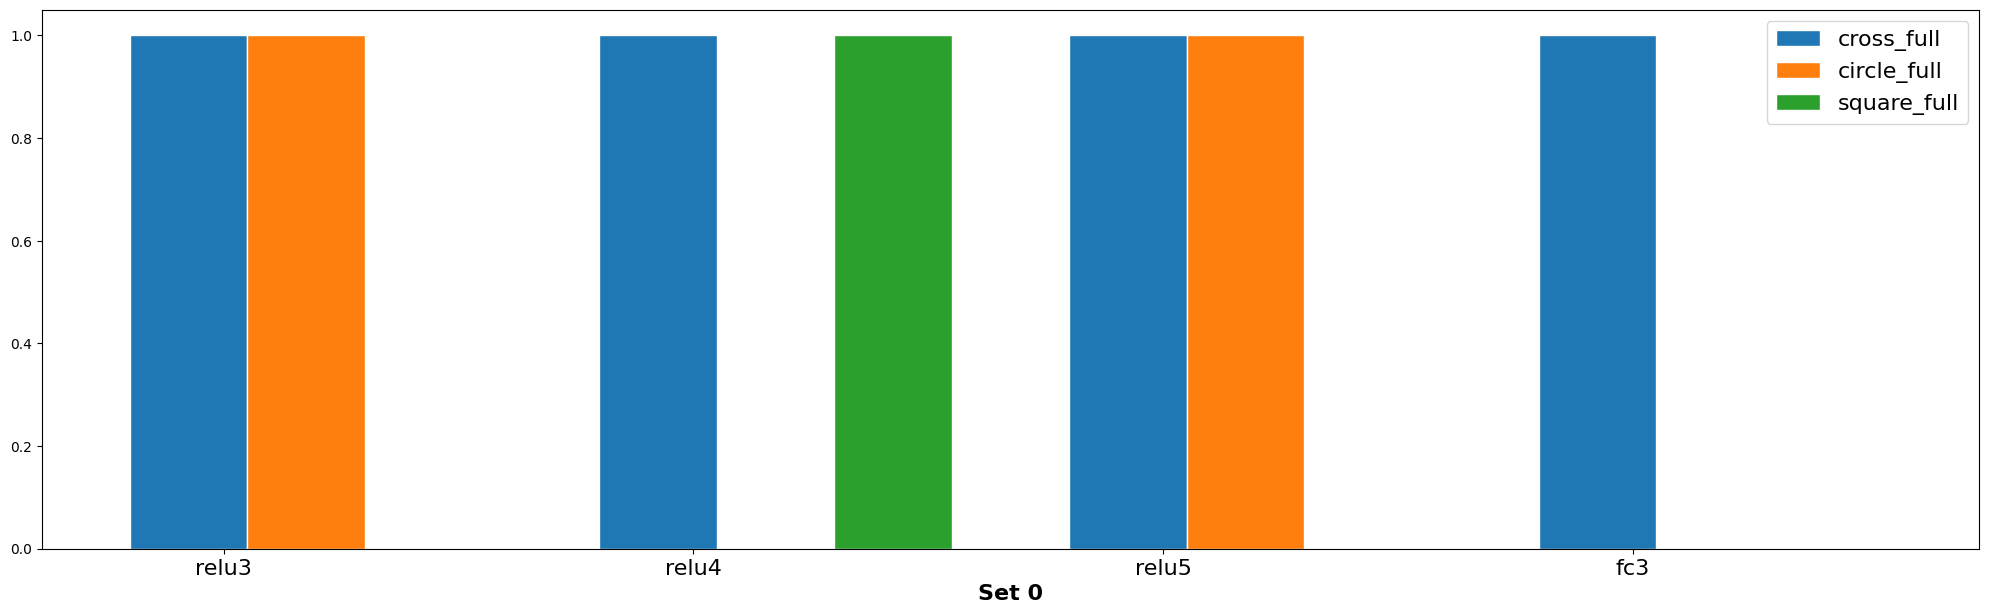

In [21]:
plot_tcav_scores(experimental_set_shapes, scores_shapes)

In [20]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(LAYER_NAMES))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(LAYER_NAMES))])
        _ax.set_xticklabels(LAYER_NAMES, fontsize=16)

        
        _ax.legend(fontsize=16)

    plt.show()

def plot_tcav_scores_vertical(experimental_sets, tcav_scores, layer_names=None):
    import numpy as np
    import matplotlib.pyplot as plt

    layers = layer_names or LAYER_NAMES
    n_sets = len(experimental_sets)

    
    fig, axes = plt.subplots(n_sets, 1, figsize=(25, 6 * n_sets), constrained_layout=True)
    if n_sets == 1:
        axes = [axes]  

    
    for idx_es, concepts in enumerate(experimental_sets):
        ax = axes[idx_es]

        
        x = np.arange(len(layers))
        n_concepts = len(concepts)
        bar_width = 0.8 / n_concepts

        
        offsets = (np.arange(n_concepts) - (n_concepts - 1) / 2.0) * bar_width

        concepts_key = concepts_to_str(concepts)  

        for i in range(n_concepts):
            
            vals = [format_float(tcav_scores[concepts_key][layer]['sign_count'][i])
                    for layer in layers]
            ax.bar(x + offsets[i], vals, width=bar_width, edgecolor='white',
                   label=concepts[i].name)

        ax.set_title(f"Set {idx_es}", fontweight='bold', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(layers, fontsize=12, rotation=0)
        ax.set_ylabel('TCAV sign count', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(axis='y', linestyle=':', alpha=0.4)

    plt.show()

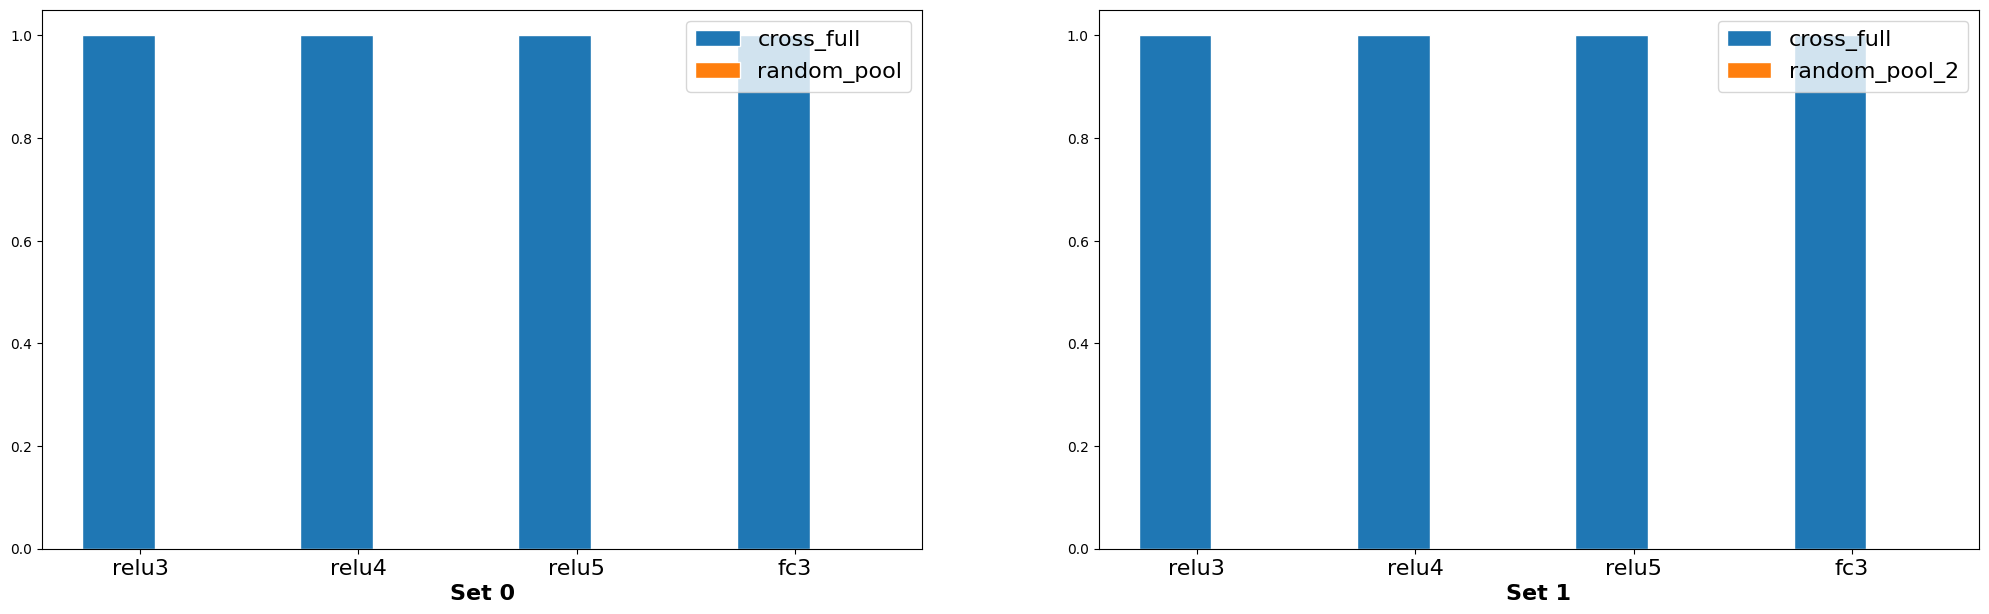

In [26]:
plot_tcav_scores(experimental_set_rand, scores_local)

In [20]:
for name, mod in model.named_modules():
    print(f"{name:15s} {mod.__class__.__name__}")

                Net
conv1           Conv2d
relu1           ReLU
bn1             BatchNorm2d
maxpool1        MaxPool2d
conv2           Conv2d
relu2           ReLU
bn2             BatchNorm2d
maxpool2        MaxPool2d
conv3           Conv2d
relu3           ReLU
bn3             BatchNorm2d
maxpool3        MaxPool2d
conv4           Conv2d
relu4           ReLU
bn4             BatchNorm2d
maxpool4        MaxPool2d
conv5           Conv2d
relu5           ReLU
bn5             BatchNorm2d
maxpool5        MaxPool2d
fc1             Linear
dropout1        Dropout
relu6           ReLU
fc2             Linear
dropout2        Dropout
relu7           ReLU
fc3             Linear
dropout3        Dropout
relu8           ReLU
fc4             Linear


In [ ]:
import re
import random
from typing import Dict, List, Tuple

random.seed(0)

FIGURE_PREFIXES = {
    "circle": r"^circle_",
    "cross" : r"^cross_",
    "square": r"^square_",
}

FULL_NAME = "full"  


def list_concept_dirs(concepts_path: str) -> List[str]:
    names = []
    for p in Path(concepts_path).iterdir():
        if p.is_dir():
            names.append(p.name)
    return sorted(names)


def split_full_vs_partials(all_names: List[str]) -> Dict[str, Dict[str, List[str]]]:
    """
    Returns:
      {
        'circle': {'full': ['circle_full'], 'partials': ['circle_half_top', ...]},
        'cross':  {'full': ['cross_full'],  'partials': ['cross_arm_left', ...]},
        'square': {'full': ['square_full'], 'partials': ['square_edge_top', ...]},
        'random': {'full': [], 'partials': ['random_pool', 'random_pool_2', ...]}
      }
    """
    groups = {k: {"full": [], "partials": []} for k in list(FIGURE_PREFIXES) + ["random"]}

    for name in all_names:
        if name.startswith("random_pool"):
            groups["random"]["partials"].append(name)
            continue

        matched = False
        for fig, pattern in FIGURE_PREFIXES.items():
            if re.match(pattern, name):
                if name.endswith("_" + FULL_NAME):
                    groups[fig]["full"].append(name)
                else:
                    groups[fig]["partials"].append(name)
                matched = True
                break

        if not matched:
            
            pass

    return groups


def assemble_many(names: List[str], start_id: int, concepts_path: str) -> Tuple[List[Concept], int]:
    """
    Turn a list of folder names into Concept objects with unique IDs.
    Returns (concepts, next_id_after).
    """
    concepts = []
    cid = start_id
    for n in names:
        concepts.append(assemble_concept(n, cid, concepts_path=concepts_path))
        cid += 1
    return concepts, cid


def pick_concepts(concepts_path: str,
                  fractions_per_figure: int = 2,
                  include_full_each: bool = True,
                  max_random_pools: int = 2,
                  start_id: int = 0) -> Dict[str, List[Concept]]:
    """
    Selects 1 FULL per figure + a few partials from each figure + random pools.
    Returns dict with keys: 'full', 'partials', 'random'
    """
    all_dirs = list_concept_dirs(concepts_path)
    groups = split_full_vs_partials(all_dirs)

    selected_full_names = []
    selected_partial_names = []
    selected_random_names = []

    
    if include_full_each:
        for fig in ["circle", "cross", "square"]:
            if groups[fig]["full"]:
                
                selected_full_names.append(sorted(groups[fig]["full"])[0])

    
    for fig in ["circle", "cross", "square"]:
        parts = sorted(groups[fig]["partials"])
        if parts:
            k = min(fractions_per_figure, len(parts))
            
            chosen = parts[:k]
            selected_partial_names.extend(chosen)

    
    random_pools = sorted(groups["random"]["partials"])
    if random_pools:
        selected_random_names = random_pools[:max_random_pools]

    
    concepts = {"full": [], "partials": [], "random": []}
    cid = start_id
    if selected_full_names:
        full_objs, cid = assemble_many(selected_full_names, cid, concepts_path)
        concepts["full"].extend(full_objs)
    if selected_partial_names:
        part_objs, cid = assemble_many(selected_partial_names, cid, concepts_path)
        concepts["partials"].extend(part_objs)
    if selected_random_names:
        rand_objs, cid = assemble_many(selected_random_names, cid, concepts_path)
        concepts["random"].extend(rand_objs)

    return concepts


def build_experimental_sets(positives: List[Concept],
                            randoms: List[Concept],
                            randoms_per_concept: int = 2) -> List[List[Concept]]:
    """
    For each positive concept, pair it with up to `randoms_per_concept` random pools,
    e.g. [[pos, rand0], [pos, rand1], ...]
    """
    if not positives or not randoms:
        return []
    sets = []
    for pos in positives:
        
        for i in range(min(randoms_per_concept, len(randoms))):
            sets.append([pos, randoms[i]])
    return sets


In [ ]:
concepts_path = "./data/concepts"


picked = pick_concepts(
    concepts_path=concepts_path,
    fractions_per_figure=3,
    include_full_each=True,
    max_random_pools=2,
    start_id=0
)

full_concepts     = picked["full"]      
partial_concepts  = picked["partials"]  
random_concepts   = picked["random"]    


experimental_sets_full = build_experimental_sets(full_concepts, random_concepts, randoms_per_concept=2)


experimental_sets_full_and_partials = build_experimental_sets(
    full_concepts + partial_concepts, random_concepts, randoms_per_concept=2
)

scores_local = mytcav.interpret(
    inputs=x_local,                          
    experimental_sets=experimental_sets_full,
    target=None,                             
    n_steps=8,
    internal_batch_size=1,
    
)


/opt/miniconda3/lib/python3.12/site-packages/captum/_utils/models/linear_model/train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


In [14]:
scores_local


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-12': defaultdict(None,
                         {'relu3': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 51.3261, -51.3261])},
                          'relu4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 36.5966, -36.5966])},
                          'relu5': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 39.2061, -39.2061])},
                          'fc3': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 12.1675, -12.1675])}}),
             '0-13': defaultdict(None,
                         {'relu3': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 38.5255, -38.5255])},
                          'relu4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 28.7838, -28.7838])},
   

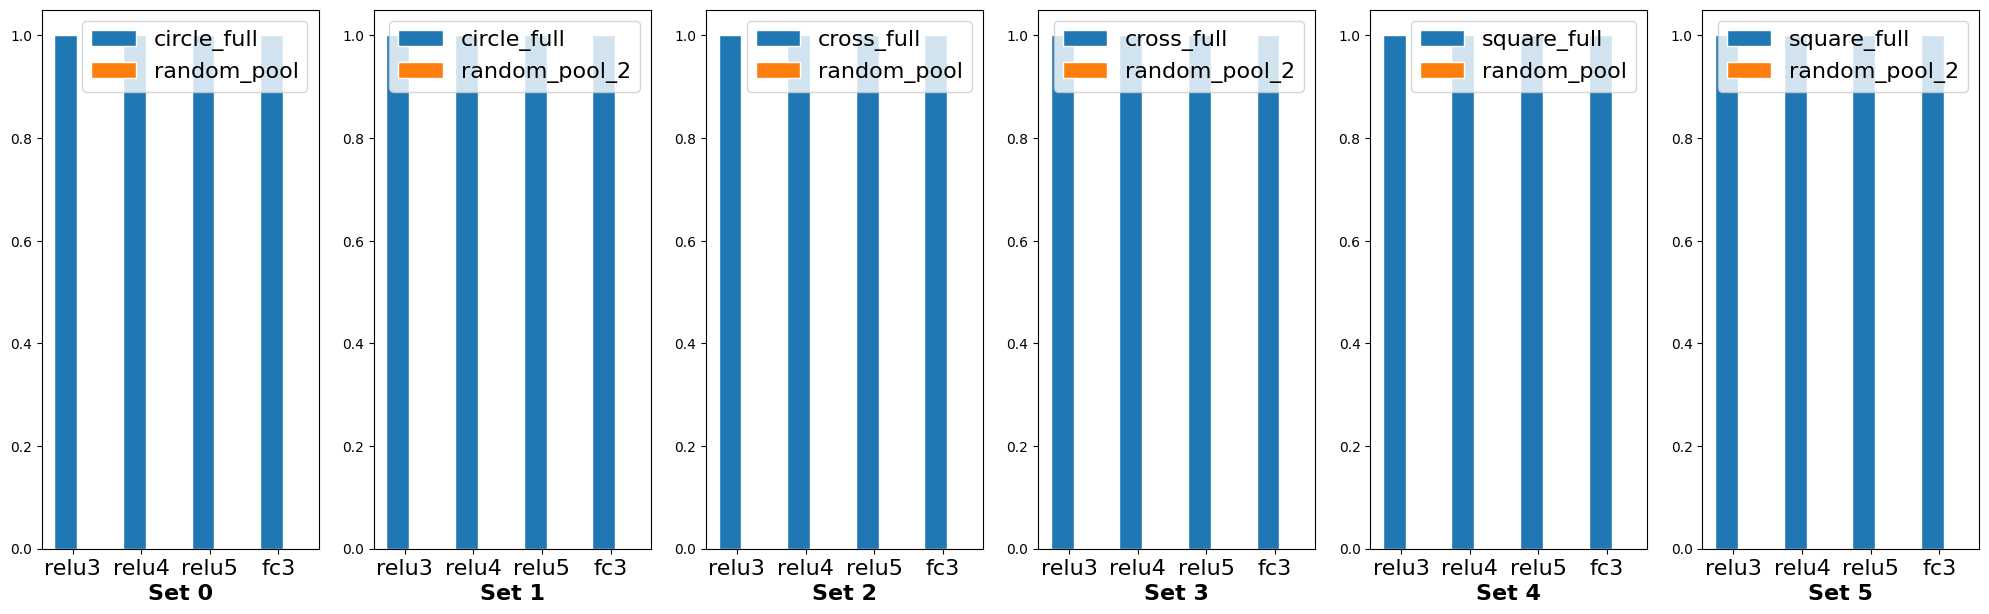

In [16]:
plot_tcav_scores(experimental_sets_full, scores_local)

In [22]:
def _to_float(x):
    return x.item() if hasattr(x, "item") else float(x)

def plot_tcav_directional(experimental_sets, tcav_scores, layer_names=None, show_sign_dots=True):
    """
    Plots signed TCAV 'magnitude' for each concept at each layer.
    Positive bar: increases the target logit. Negative: decreases it.
    Optionally overlays a dot based on majority sign from 'sign_count'.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    
    def present_layers_for_key(ck, preferred):
        return [ly for ly in (preferred or []) if ly in tcav_scores[ck]]

    n_sets = len(experimental_sets)
    fig, axes = plt.subplots(n_sets, 1, figsize=(24, 5 * n_sets), constrained_layout=True)
    if n_sets == 1:
        axes = [axes]

    for idx_es, concepts in enumerate(experimental_sets):
        ck = concepts_to_str(concepts)
        
        preferred = layer_names if layer_names else list(tcav_scores[ck].keys())
        layers = present_layers_for_key(ck, preferred) or list(tcav_scores[ck].keys())

        ax = axes[idx_es]
        x = np.arange(len(layers))
        n_concepts = len(concepts)
        bar_w = 0.8 / max(1, n_concepts)
        offsets = (np.arange(n_concepts) - (n_concepts - 1) / 2.0) * bar_w

        
        for i in range(n_concepts):
            vals = [ _to_float(tcav_scores[ck][ly]['magnitude'][i]) for ly in layers ]
            ax.bar(x + offsets[i], vals, width=bar_w, edgecolor='white', label=concepts[i].name)

            if show_sign_dots and 'sign_count' in tcav_scores[ck][layers[0]]:
                
                sc = [ _to_float(tcav_scores[ck][ly]['sign_count'][i]) for ly in layers ]
                
                
                dots_y = []
                for ly_idx, ly in enumerate(layers):
                    sc_i = _to_float(tcav_scores[ck][ly]['sign_count'][i])
                    
                    try:
                        max_sc_layer = max(_to_float(tcav_scores[ck][ly]['sign_count'][j]) for j in range(n_concepts))
                    except Exception:
                        max_sc_layer = 1.0
                    
                    majority_up = sc_i > (max_sc_layer / 2.0)
                    
                    dots_y.append(0.02 if majority_up else -0.02)
                ax.scatter(x + offsets[i], dots_y, s=30, marker='o')

        ax.axhline(0.0, color='k', linewidth=1)
        ax.set_title(f"Set {idx_es}: " + ", ".join([c.name for c in concepts]), fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(layers, rotation=0, fontsize=12)
        ax.set_ylabel("Signed TCAV magnitude (↑ pushes logit, ↓ lowers logit)", fontsize=12)
        ax.grid(axis='y', linestyle=':', alpha=0.35)
        ax.legend(fontsize=11)

    plt.show()


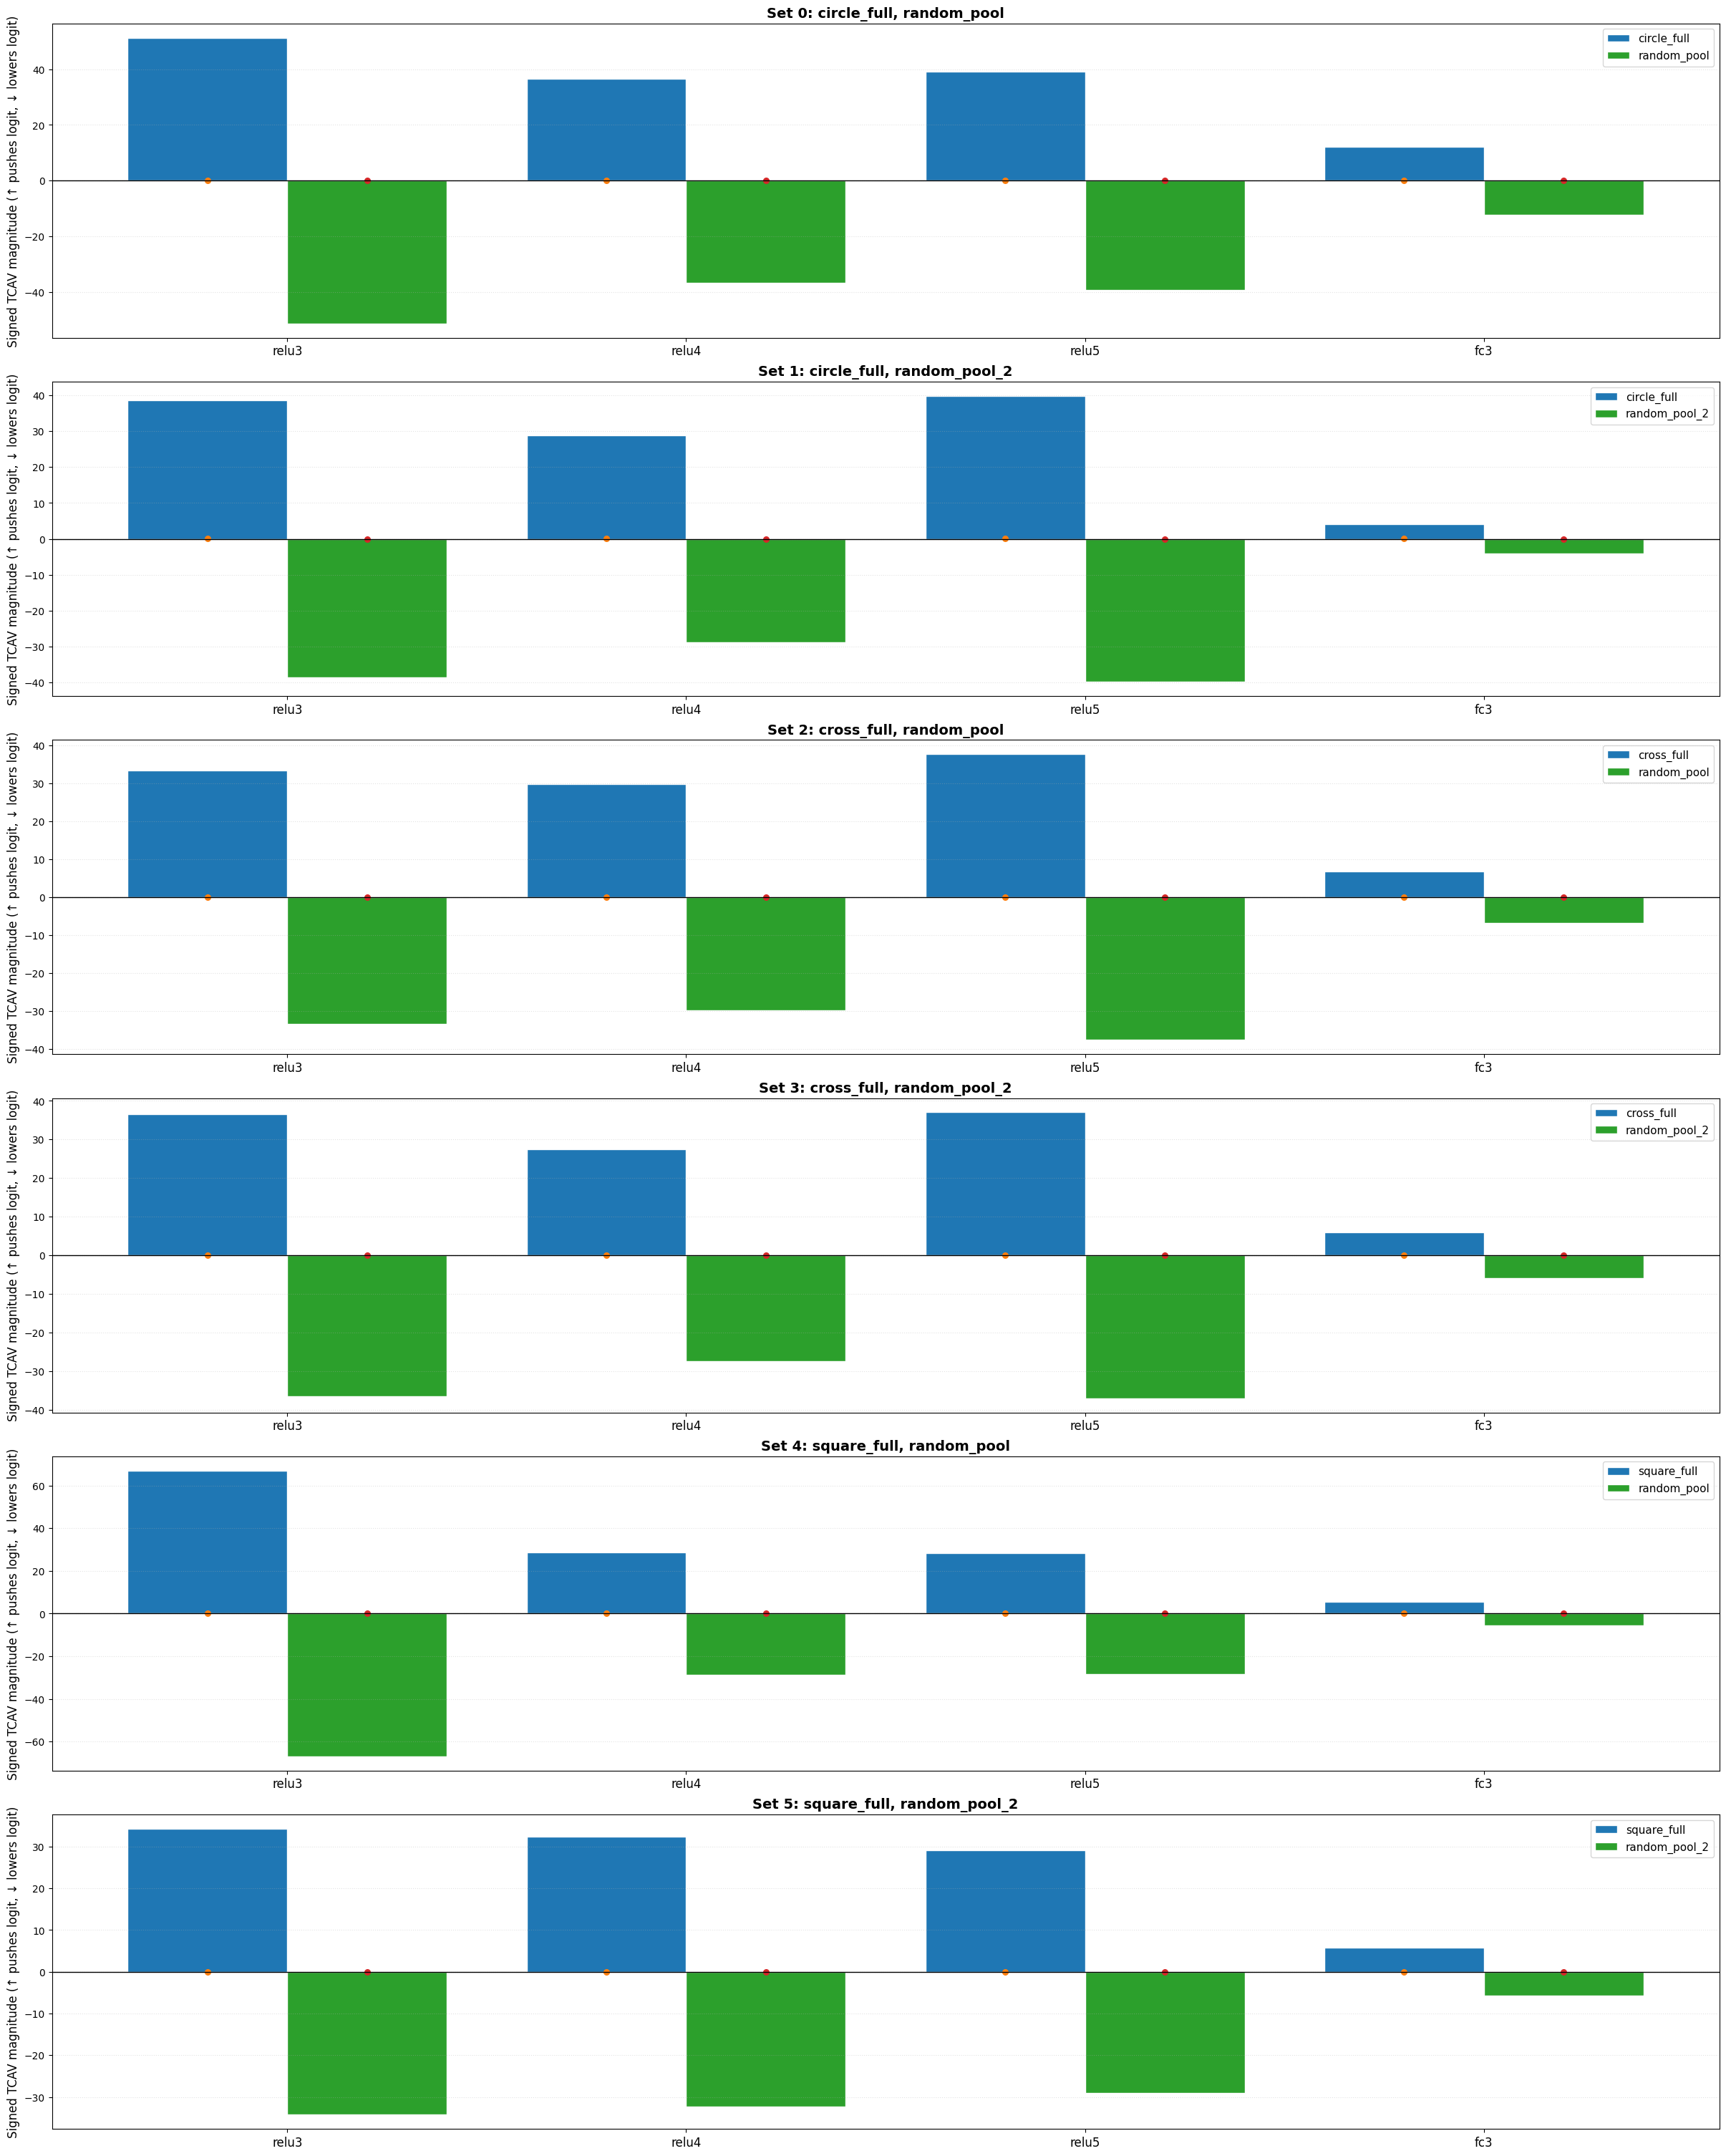

In [18]:
plot_tcav_directional(experimental_sets_full, scores_local, layer_names=LAYER_NAMES)

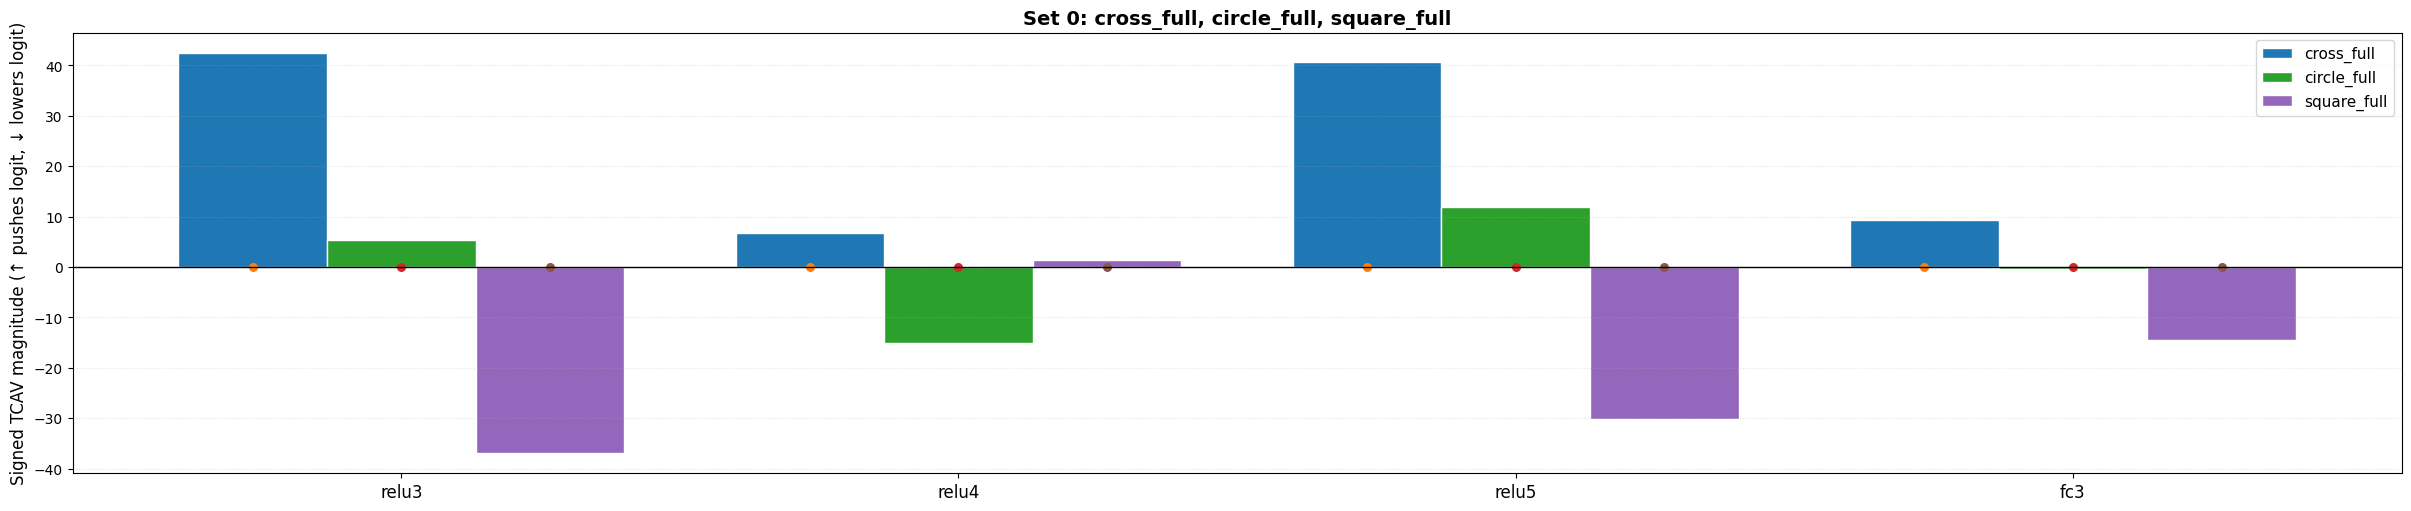

In [23]:
plot_tcav_directional(experimental_set_shapes, scores_shapes)